# Language Modelling with RNNs

Deepam Minda  
2024-07-20

# Introduction

The only reason you would be hearing RNNs right now is probably when
[xLSTMs](https://arxiv.org/pdf/2405.04517) were released in May, 2024.
Apart from this they have pretty much taken a back seat to watch
transformers revolutionalize NLP and the entire field of AI in general.

But one would do well to remember how we got here, and RNNs played a
massive role in bringing us here. So in this blog post I’m going to
build a small RNN model and we’ll try to train it to generate text.

# Import data and process it

In [18]:
import torch
import torch.nn as nn
import random
import numpy as np 
from tqdm import tqdm

Let us load a text dataset. I downloaded a few mystery books and
concatenated their raw text to make the dataset. Follow
[this](https://github.com/mindadeepam/mindadeepam.github.io/blob/posts/posts/rnns/corpus.txt)
link to get the text file.

In [5]:
dataset_path = "/Users/deepamminda/Downloads/corpus.txt"

with open(dataset_path, 'r') as f:
    data = f.read()
print(f"the size of data: {len(data)} characters")

the size of data: 3062155 characters

Lets have a look at some of the text we have.

In [7]:
print(f"Sample data chunk:\n'{data[1500:2500]}'")

Sample data chunk:
'n one of his own high-power lenses, would not
be more disturbing than a strong emotion in a nature such as his. And
yet there was but one woman to him, and that woman was the late Irene
Adler, of dubious and questionable memory.

I had seen little of Holmes lately. My marriage had drifted us away
from each other. My own complete happiness, and the home-centred
interests which rise up around the man who first finds himself master
of his own establishment, were sufficient to absorb all my attention,
while Holmes, who loathed every form of society with his whole Bohemian
soul, remained in our lodgings in Baker Street, buried among his old
books, and alternating from week to week between cocaine and ambition,
the drowsiness of the drug, and the fierce energy of his own keen
nature. He was still, as ever, deeply attracted by the study of crime,
and occupied his immense faculties and extraordinary powers of
observation in following out those clues, and clearing up those
m

Lets split the data into train and test (80-20)

In [8]:
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

print(f"train_size: {len(train_data)}, test_size: {len(test_data)}  (in number of tokens)")

train_size: 2449724, test_size: 612431  (in number of tokens)

Now let us encode the text to numerical data that our model can
understand. Encoding the data generally means tokenization and then
encoding. To keep it super simple, we’ll just use individual characters
as tokens.

Nowadays however, subword [tokenization
algorithms]((https://huggingface.co/docs/transformers/main/en/tokenizer_summary))
like Byte-Pair Encoding are the norm. But let us not get caught up in
those for now.

In [10]:
# Define the vocabulary and special tokens
vocab = list(set(train_data+"12345678910qwertyuioplkjhgfdsamnbvcxz~!@#$%^&*()_+`-=[];'./,{}\":?><\|"))
PAD_TOKEN = '<pad>'
special_tokens = [PAD_TOKEN]
MAX_SEQ_LEN = 32

vocab = [*special_tokens, *vocab]

# Create mappings for encoding and decoding
decode_mapping = dict(enumerate(vocab))
encode_mapping = {v:k for k,v in decode_mapping.items()}

# Define encoding and decoding functions
encode = lambda text: [encode_mapping[char] for char in text]
decode = lambda text: [decode_mapping[char] for char in text]

Now we can do a simple sanity check by encoding a text and decoding it.
we should get the original string back.

In [11]:
text = "hey there"
encoded_text = encode(text)

print(f"original text: {text}")
print(f"tokenized text: {list(text)}")
print(f'encoded text: {encoded_text}')
print(f"decoded back:{decode(encoded_text)}")

original text: hey there
tokenized text: ['h', 'e', 'y', ' ', 't', 'h', 'e', 'r', 'e']
encoded text: [104, 81, 106, 37, 89, 104, 81, 8, 81]
decoded back:['h', 'e', 'y', ' ', 't', 'h', 'e', 'r', 'e']

Now we need functions that will do this for batches of texts rather than
single text. When dealing with batches, there are a few extra
considerations: - You would typically want your batches to contain texts
which are of same length, so that matrix/tensor operations can be
performed. Hence we need to truncate longer sentences and pad shorter
sentences to a fixed length.

For simplicity let us also define a function that will fetch us a random
batch of data from our training set.

In [13]:
def get_data(data, batch_size=16, seq_len=256):
    """
    Retrieves input and target data for training a recurrent neural network (RNN).

    Args:
        data (list): The input data.
        batch_size (int, optional): The number of sequences in each batch. Defaults to 16.
        seq_len (int, optional): The length of each sequence. Defaults to 256.

    Returns:
        tuple: A tuple containing the input and target data tensors.
            - inputs (torch.Tensor): The input data tensor.
            - targets (torch.Tensor): The target data tensor.
    """
    buffer = 1000
    l = len(data)
    start = np.random.randint(0, l - buffer, size=batch_size)
    end = start + seq_len
    texts = [data[s:e] for s, e in zip(start, end)]
    
    encoded_texts = encode_arr(texts, max_seq_len=seq_len + 1)
    targets = encoded_texts[:, 1:]
    inputs = encoded_texts[:, :-1]
    
    targets = torch.tensor(targets, dtype=torch.long)
    inputs = torch.tensor(inputs, dtype=torch.long)
    
    return inputs, targets



In [14]:
x, y = get_data(train_data, 4, 23)
print("target is just x shifted one token to the left!")
print(f"x[0]: {x[0]},\ny[0] {y[0]}")

target is just x shifted one token to the left!
x[0]: tensor([  0,  81,   8, 112,  37,  49,  21,  37,  31,  37,  47,  31,  79,  37,
        100, 104,  49,  37,  97,  96,  37,  96,  89]),
y[0] tensor([ 81,   8, 112,  37,  49,  21,  37,  31,  37,  47,  31,  79,  37, 100,
        104,  49,  37,  97,  96,  37,  96,  89,   8])

# RNNs

Now before modelling, let us look at a RNN layer and understand its
input and outputs. Each RNN layer has the following basic archtecture:

<figure id="fig-unrolled-rnn">
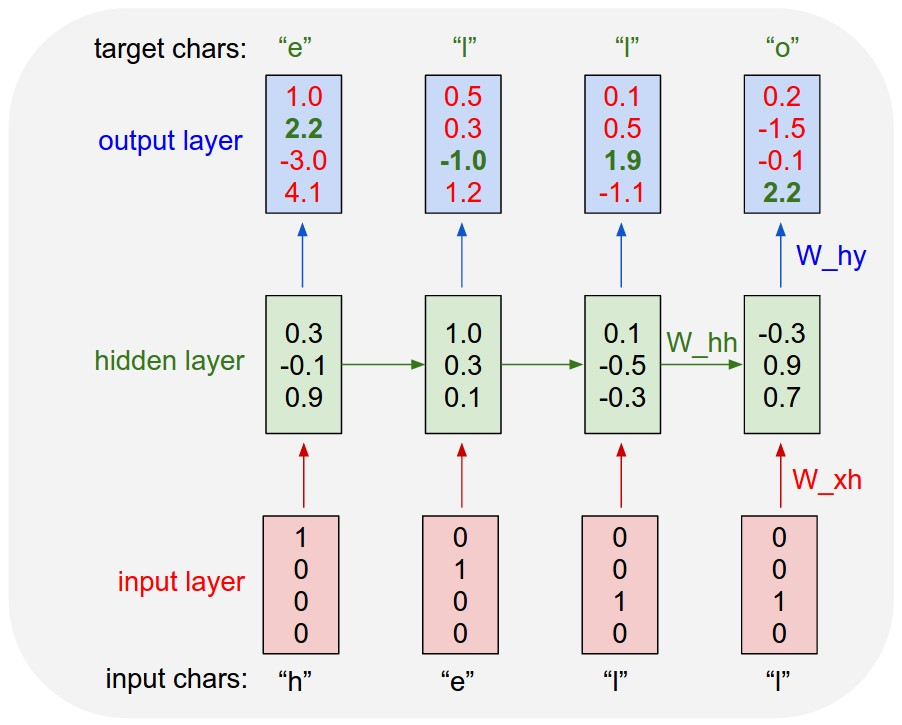
<figcaption>Figure 1: unrolled RNN</figcaption>
</figure>

## Understanding RNNs

RNNs have 2 matrices, one ($W_{xh}$) that maps input tokens to
hidden_vector size and another ($W_{hh}$) that maps from hidden_vector
to hidden_vector. You’ll see how these are used in a minute.

Let us first look at input-output shapes for an RNN layer. We initially
had a batch of text-tokens. Lets assume batch size of 4 and max_seq_len
of 32. Hence the shape of input is (4,32).

Now for each token, we encode it to a number and then map it to a vector
(which we generally call an embedding). Hence each token is now
represented by a vector of fixed-shape, and lets call this
embedding_dimension and set it to 10. (This can also be done by
classical methods like one-hot encoding, ngram-models)

The shape of our input batch is now (batch_size, max_seq_len, emb_dim),
ie (4,32,10).

Now let us peek into the matrix multiplications inside a RNN layer.
Firstly, lets us recall that for a linear layer, this is the matrix
equation:

$z (N, n_{out}) = \sigma(x (N, n_{in}) * W_x^T (n_{in}, n_{out}) + b (N))$

where ,

-   input-features = $n_{in}$
-   output-features = $n_{out}$
-   batch-size = $N$

In a linear layer, each token/feature is attended to by a different
weight in the weight matrix and no information is shared among the
sequence tokens. But when processing “sequences” we obviously want the
model to remember stuff from previous tokens for the current token,
right?

Hence RNNs maintain a hidden_vector for each token, that takes as input
the current token and the hidden_vector from the previous token’s
output.

So for the $t$’th token,

$h_t (N, h)= x_t (N, n_{in}) * W_{xh}^T (n_{in}, h) + h_{t-1} (N, h) * W_{hh}^T (h, h) + biases$

where

-   input-features = $n_{in}$
-   hidden-size = $h$
-   batch-size = $N$
-   sequence-length = $s$

As you’ll notice since each token depends on previous tokens output, we
cannot process this parallelly and have to iteratively calculate the
output for each token. Also note we generally refer to the different
tokens in a sequence as different timesteps, ie token at timestep t is
$x_t$.

Hence for a complete batch, inputs are:

-   $X$ of shape $(N, s, n_{in})$
-   $h_0$ of shape $(N, h)$ (this is optional, if not given most
    libraries will initiate a $h_0$ of all zeros or random numbers)

And outputs are:

-   hidden states of all timesteps, ie $H$ of shape $(N, s, h)$
-   last_hidden_state ie $h_n$ of shape $(N, h)$

Note: sometimes you will see outputs of rnn fed into a linear layer like
so,

``` python
outputs, h_n = self.rnn(x)
y = self.fc(outputs[:,-1,:])
```

Here `h_n` and `outputs[:,-1,:]` are the same thing. They both represent
the last hidden state for the entire batch. (to make shapes equal use
`h_n.squeeze()`)

Lets verify the above by passing inputs to an rnn layer.

In [19]:
emb_dim = 128
hidden_size = 128
batch_size = 8
max_seq_len = 32

print(f"batch_size: {batch_size}, hidden_size: {hidden_size}, max_seq_len: {max_seq_len}, emb_dim: {emb_dim}")
X,y = get_data(train_data, seq_len=max_seq_len, batch_size=batch_size)
print(f"shape of initial input -> {X.shape}")

emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=emb_dim)
rnn_layer = nn.RNN(input_size=emb_dim, hidden_size=hidden_size, batch_first=True, bidirectional=False, num_layers=1)

X = emb_layer(X)
print(f"post embedding; shape of input to RNN layer -> {X.shape}")
h_0 = torch.randn(1, batch_size, hidden_size)
outputs = rnn_layer(X, h_0)

print(f"RNN output shapes -> {outputs[0].shape}, {[outputs[1][i].shape for i in range(len(outputs[1]))]}")

batch_size: 8, hidden_size: 128, max_seq_len: 32, emb_dim: 128
shape of initial input -> torch.Size([8, 32])
post embedding; shape of input to RNN layer -> torch.Size([8, 32, 128])
RNN output shapes -> torch.Size([8, 32, 128]), [torch.Size([8, 128])]

# Language Modelling

Now let us build a model and train it. For starters we’ll just use a
[torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN)
layer to build the model and train it. Once we get the entire training
and testing pipeline complete, we can come back and build the model from
scratch.

### How exactly can we generate text though?

We know we can get hidden states of the entire sequence as outputs from
a rnn layer, but each hidden state $h_t$ has ponly seen information till
timestep $t$. What we can do is this:

-   only use the last hidden state and feed it to a linear layer with
    output shape equal to size of vocabulary.
-   if softmax is applied on top of the linear layer’s output, it turns
    raw logits into the probabilities for different tokens in our vocab.
    This can be done outside the forward function too.

Now each input sequence gives us one output token ie $y_{t+1}$. then we
can take the sequence from $1$ to $t+1$ and generate token $y_{t+2}$.

### During Training

To maximize training we can use all hidden state outputs instead of the
last one. Because why wouldnt we want the model to learn from all its
outputs!

-   output of rnn layer of shape $(N, s, h)$ is fed into a linear layer
    of shape $(h, vocab\_size)$ to get $(N,s,vocab\_size)$ outputs. then
    we can pass them via softmax and apply cross-entropy loss on all of
    them and backpropagate through the model.
-   since at token level we now have $N*s$ tokens on which we will
    calculate loss, its simpler to flatten the targets and generated
    logits before passing to cross-entropy loss.

Note: Had it been a classification task, we could just pass last
hidden_state, $h_n$ to a linear layer with output size equal to number
of classes.

## The model

In [55]:
# calculate size of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class Rnn_model(nn.Module):

    def __init__(self, embedding_size, max_seq_len, hidden_size, num_layers=1, vocab_size=None):
        """
        Initializes the Rnn_model class.

        Args:
            embedding_size (int): The size of the embedding dimension.
            max_seq_len (int): The maximum sequence length.
            hidden_size (int): The size of the hidden state dimension.
            num_layers (int, optional): The number of recurrent layers. Defaults to 1.
            vocab_size (int, optional): The size of the vocabulary. Defaults to None.

        """
        super(Rnn_model, self).__init__()

        self.max_seq_len = max_seq_len
        self.vocab_size = len(vocab) if vocab_size is None else vocab_size
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=embedding_size)
        self.rnn = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, len(vocab))
        self.softmax = nn.Softmax(dim=-1)
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore pad token

    def forward(self, x, targets=None):
        """ 
        a forward pas thorugh the model.
        x: input torch tensor (B,T,S)
        targets: input targets (B,T,S)

        Returns
        (model output logits, loss)
        """
        x = x[:, -self.max_seq_len:]
        x = self.embedding(x)
        H, h_n = self.rnn(x)

        # y = self.fc(H[:,-1,:])
        y = self.fc(H)
        
        if targets is not None:
            B, T, V = y.shape
            loss = self.criterion(y.view(B*T, V), targets.view(-1))
        else: loss=None
        
        return y, loss
    
    
    @torch.no_grad
    def generate(self, input_text, max_len=32, device='cpu'):
        """ 
        input_text: a string or list of strings to generate text using the model.
        max_len: model will generate maximum of max_len tokens.
        """
        
        encoded_tokens = torch.tensor(encode_arr([input_text], max_seq_len=32))
        if encoded_tokens.ndim == 1:
            encoded_tokens = encoded_tokens.unsqueeze(0)

        self = self.to(device)
        encoded_tokens = encoded_tokens.to(device)
        for i in range(max_len):
            # only keep the most recent seq_len sized numbers.
            outputs, _ = self(encoded_tokens[:, -self.max_seq_len:])

            # last output token
            outputs = outputs[:, -1, :]

            # get pribabilities from logits
            next_token_probs = nn.functional.softmax(outputs, dim=-1)

            # sample indices from it using a multinomial distribution
            next_tokens = torch.multinomial(next_token_probs, 1)

            # concat prediction to original text
            encoded_tokens = torch.concat((encoded_tokens, next_tokens), axis=1)

        decoded_texts = decode_arr(encoded_tokens)
        if len(decoded_texts)==1:
            return decoded_texts[0] #.replace("<pad>", "") 
        else: 
            # return [text.replace("<pad>", "") for text in decoded_texts]
            return decoded_texts

## Training loop

Now I’ll define a basic training loop to train this model, and we’ll
generate text every 1k steps to see the model learn right before us! Im
also using tensorboard to log and view my runs. IMO its the best way to
visualize loss curves and debug model behavior.

In [72]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs/with_gradients/')

NUM_STEPS = 10000
MAX_SEQ_LEN = 32
BATCH_SIZE = 32
EMBEDDING_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 2
LR = 0.001 
LOG_EVERY = 200
GENERATE_EVERY = 1000

device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

model = Rnn_model(embedding_size=EMBEDDING_SIZE, max_seq_len=MAX_SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
print(f"paramter count of the model: {count_parameters(model)}, data_size: {len(train_data)}\n")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
losses = []
for i in (range(NUM_STEPS)):
    optimizer.zero_grad()
    x, y = get_data(train_data, BATCH_SIZE, MAX_SEQ_LEN)
    
    model.to(device)
    x, y = x.to(device), y.to(device)
    outputs, loss = model(x, y)
    loss.backward()

    # clip gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Log gradients before the optimization step
    for name, param in model.named_parameters():
        if param.grad is not None:
            writer.add_histogram(f'gradients/{name}', param.grad, i)

    optimizer.step()
    if i%LOG_EVERY==0:
        losses.append(loss)
        # print(loss.item())
    
    writer.add_scalar('Loss/train', loss.item(), i)

    
    if i%GENERATE_EVERY==0 or i==NUM_STEPS-1:
        print(f"after {i} steps: ")
        prompt = 'but I told him clearly, that if'
        print(f"prompt is: {prompt}")
        gen_text = model.generate(prompt, max_len=128)
        gen_text = gen_text.replace("<pad>", "")
        print(f"\ntext generated by model: \n{gen_text}\n")
        print('-'*75)
        

writer.close()

losses = [loss.cpu().detach().numpy().item() for loss in losses] 
# print(losses[::3])

paramter count of the model: 1114232, data_size: 2449724

after 0 steps: 
prompt is: but I told him clearly, that if

text generated by model: 
but I told him clearly, that ifâDaL—WX2m‘;D3æJqèup½’VDnJi^Rjje(lSïVcCrgWmMQSXA9W9`_Fî+E5l&1sVq\6]=^fê—>804àâ!yñêI・y=6&l,{$Oû.1—u*$9‘KM!Oñ-cW’MéñhB~M.j6r{}xl

---------------------------------------------------------------------------
after 1000 steps: 
prompt is: but I told him clearly, that if

text generated by model: 
but I told him clearly, that if
Twen tracked of him grivel-napregred whotain one come,
in hy midge withoush, which shoulquould before so speeded the feet in th

---------------------------------------------------------------------------
after 2000 steps: 
prompt is: but I told him clearly, that if

text generated by model: 
but I told him clearly, that if still come, but I don’t know. Mc! So yester I shall five onnestible, “that peired, want and
asfected to his harded has
Farching

----------------------------------------------

Text(0, 0.5, 'Loss')

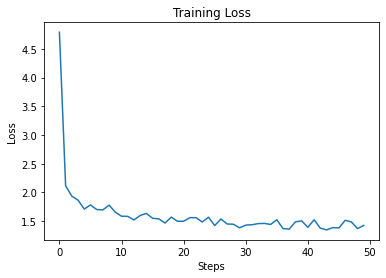

In [73]:
# plot losses
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

The results certainly improve over the iterations, and its clearly
visible that the model is learning to generate text. By scaling the
model and training for longer, we can get better results.

Thank you for reading this and I hope you found it useful. The next time
I update this blog post, I’ll be adding the following:

-   Evaluation on test set (metrics like perplexity).
-   Implementing RNN, LSTM and GRU from scratch.

Byee :)

# References

1.  OG blog by Karpathy
    [link](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
2.  RNN torch documentation
    [link](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN)
3.  Karpathy 1hr lecture on recurennt networks
    [link](https://www.youtube.com/watch?v=yCC09vCHzF8)